# Решение задачи регрессии SI

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', index_col=0)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,...,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,...,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# подготовка данных

X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)
# констатные признаки
const_features = [col for col in df.columns if df[col].std() == 0]
X = X.drop(const_features, axis=1)
X = X.fillna(X.median())

# логарифмическое преобразование чтобы получить распределение более близкое к нормальному
y = np.log1p(df['SI'])

In [ ]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
]

In [ ]:
results = []  # Будет содержать словари с метриками для каждой модели
names = []

r2_scorer = make_scorer(r2_score)

for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Вычисляем RMSE
    cv_rmse = cross_val_score(pipeline, X_train, y_train, cv=5,
                            scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_rmse)

    # Вычисляем R²
    cv_r2 = cross_val_score(pipeline, X_train, y_train, cv=5,
                          scoring=r2_scorer)

    # Сохраняем результаты
    model_results = {
        'name': name,
        'rmse_scores': rmse_scores,
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std(),
        'r2_scores': cv_r2,
        'r2_mean': cv_r2.mean(),
        'r2_std': cv_r2.std()
    }

    results.append(model_results)
    names.append(name)

    # Выводим результаты
    print(f"{name}:")
    print(f"  RMSE: Среднее = {rmse_scores.mean():.4f}, STD = {rmse_scores.std():.4f}")
    print(f"  R²: Среднее = {cv_r2.mean():.4f}")
    print("-" * 50)

Linear Regression:
  RMSE: Среднее = 224.5616, STD = 442.2472
  R²: Среднее = -116643.7402
--------------------------------------------------
Ridge Regression:
  RMSE: Среднее = 1.6383, STD = 0.5271
  R²: Среднее = -0.4893
--------------------------------------------------
Lasso Regression:
  RMSE: Среднее = 1.4299, STD = 0.0451
  R²: Среднее = -0.0061
--------------------------------------------------
Random Forest:
  RMSE: Среднее = 1.2019, STD = 0.0542
  R²: Среднее = 0.2880
--------------------------------------------------
XGBoost:
  RMSE: Среднее = 1.2763, STD = 0.0537
  R²: Среднее = 0.1961
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15025
[LightGBM] [Info] Number of data points in the train set: 640, number of used featu

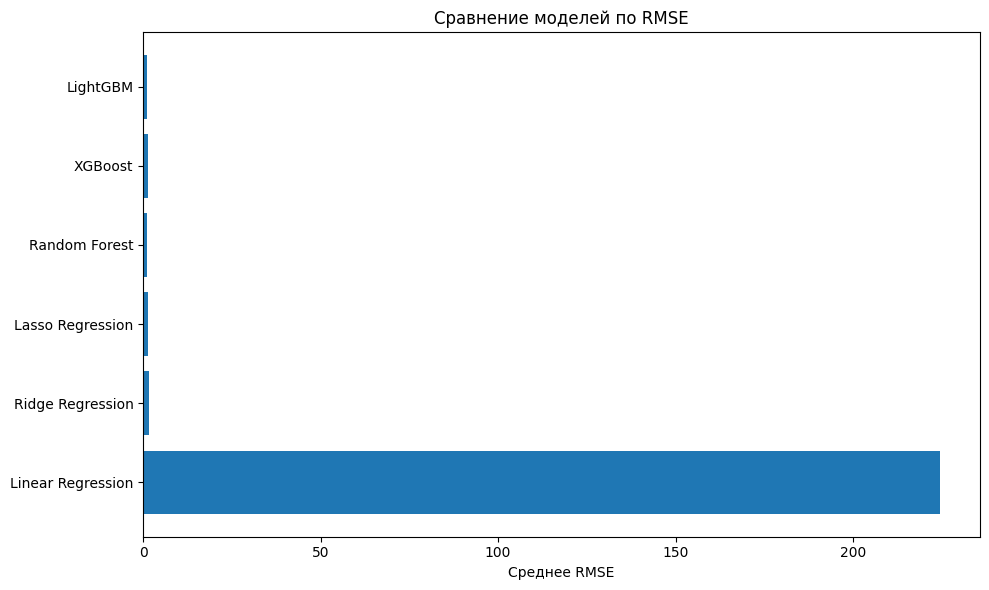

In [ ]:
# Визуализация
rmse_means = [res['rmse_mean'] for res in results]
names = [res['name'] for res in results]

# График для RMSE
plt.figure(figsize=(10, 6))
plt.barh(names, rmse_means)
plt.title('Сравнение моделей по RMSE')
plt.xlabel('Среднее RMSE')
plt.tight_layout()
plt.show()

In [ ]:
# Подбор гиперпараметров для Ridge Regression

param_grid_ridge = {
    'model__alpha': [0.1, 1.0, 10.0],
}

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])

grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_ridge.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_ridge.best_score_))

Лучшие гиперпараметры: {'model__alpha': 10.0}
Лучший RMSE: 1.6465280835126677


In [ ]:
# Подбор гиперпараметров для Lasso Regression

param_grid_lasso = {
    'model__alpha': [0.1, 1.0, 10.0],
}

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=42))
])

grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_lasso.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_lasso.best_score_))

Лучшие гиперпараметры: {'model__alpha': 0.1}
Лучший RMSE: 1.354734375363072


In [ ]:
# Подбор гиперпараметров для случайного леса

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_rf.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_rf.best_score_))

Лучшие гиперпараметры: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Лучший RMSE: 1.1897440650744668


In [ ]:
# Подбор гиперпараметров для XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1]
}

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42))
])

grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_xgb.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_xgb.best_score_))

Лучшие гиперпараметры: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Лучший RMSE: 1.20590517254231


In [ ]:
# Подбор гиперпараметров для LightGBM
param_grid_lgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1]
}

pipeline_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_lgb.best_params_)
print("Лучший RMSE:", np.sqrt(-grid_lgb.best_score_))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17996
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 168
[LightGBM] [Info] Start training from score 2.050056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Лучшие результаты показала модель LightGBM
И близкое значение метрики у случйного леса. Посмотрим качество предсказаний на тестовых данных

In [ ]:
# лучшая модель случайного леса
best_model_rf = grid_rf.best_estimator_

# Предсказания на тестовых данных
y_pred = best_model_rf.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Оценки метрик на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Оценки метрик на тестовых данных:
MSE: 1.5977
RMSE: 1.2640
R2: 0.3398
MAE: 0.9339


In [ ]:
# лучшая модель LightGBM
best_model_lgb = grid_lgb.best_estimator_

# Предсказания на тестовых данных
y_pred = best_model_lgb.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Оценки метрик на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")

Оценки метрик на тестовых данных:
MSE: 1.6999
RMSE: 1.3038
R2: 0.2976
MAE: 0.9454


Случайный лес дает лучшие результаты


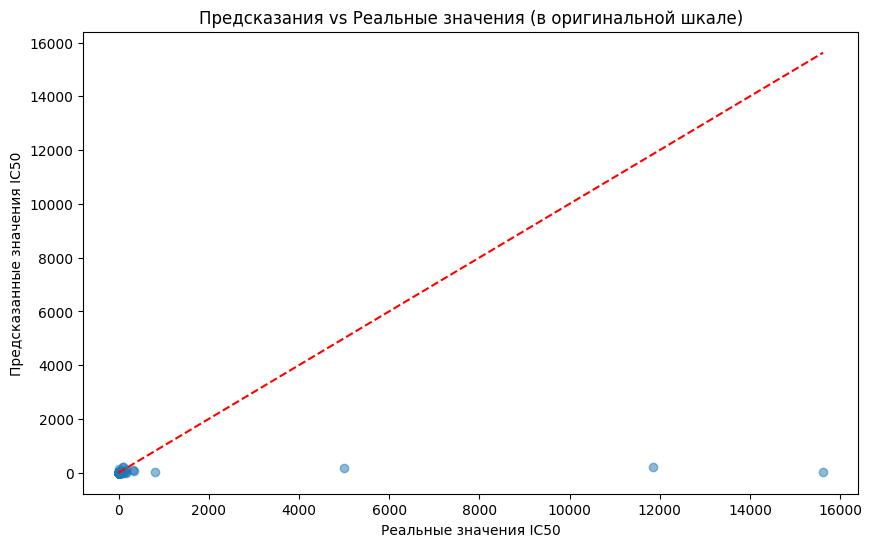

In [ ]:
# Визуализация предсказаний vs реальные значения
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], '--r')
plt.xlabel('Реальные значения IC50')
plt.ylabel('Предсказанные значения IC50')
plt.title('Предсказания vs Реальные значения (в оригинальной шкале)')
plt.show()

           feature  importance
98     VSA_EState6    0.058651
100    VSA_EState8    0.057067
67        SMR_VSA7    0.054362
20    BCUT2D_CHGLO    0.041830
24    BCUT2D_MRLOW    0.031653
18    BCUT2D_MWLOW    0.028706
4              qed    0.021227
19    BCUT2D_CHGHI    0.020001
119      RingCount    0.018910
21   BCUT2D_LOGPHI    0.018443


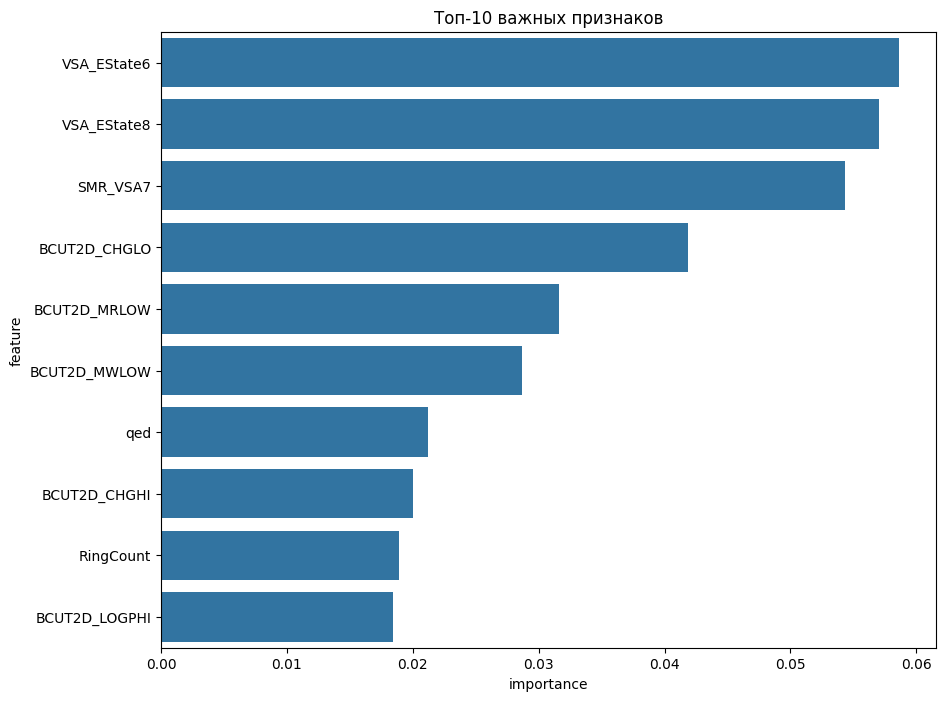

In [ ]:
# Важность признаков лучшей модели
feature_importance = best_model_rf.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df[:10])
# Топ 10 важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Топ-10 важных признаков')
plt.show()

## Выводы


Наилучшая модель - случайный лес  

Оценки метрик на тестовых данных:
MSE: 1.5977  
RMSE: 1.2640  
R2: 0.3398  
MAE: 0.9339  

R2: 0.3398   => модель объясняет около 34% дисперсии данных

Наиболее важные признаки для решения задачи регрессии CC50:   
- VSA_EState6   
- VSA_EState8   
- SMR_VSA7   
- BCUT2D_CHGLO  
- BCUT2D_MRLOW  
- BCUT2D_MWLOW   
- qed   
- BCUT2D_CHGHI   
- RingCount  
- BCUT2D_LOGPHI

Рекоммендаци по улучшению результатов предсказания:
- Более тщательный подбор гиперпараметров моделей
- Использовать методы для снижения размерности
- Использовать Feature Engineering